<a href="https://colab.research.google.com/github/khaoulaloudiyi/QuickNews/blob/master/fakeNews.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [2]:
!pwd

/content


In [3]:
cd /content/drive/My Drive/fakeNews

/content/drive/My Drive/fakeNews


In [4]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re as re
import scipy.stats as stats
import math
from textblob import TextBlob
from sklearn import metrics 
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix
from sklearn.metrics import auc
from sklearn.linear_model import LogisticRegression
import scipy.stats as stats
import keras
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, Activation, Dropout
from keras.callbacks import EarlyStopping
from sklearn.model_selection import GridSearchCV
from nltk.corpus import stopwords
from nltk import word_tokenize


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [5]:
def findlength(dataframe, column_name):
    
    """
    findLength returns the length of text entries
    Parameters
    ----------
    dataframe : DataFrame
        A pandas DataFrame object. 
    column_name: String
        Name of the DataFrame column that contains text
    Returns
    -------
        Length of text entries
    """

    length_te = [len(str(words)) for words in dataframe[column_name]]
    
    return length_te

def null_plot(df, kind):
    
    """
    null_plot plots null counts of each column of the DataFrame
    Parameters
    ----------
    df : DataFrame
        A pandas DataFrame object. 
    kind : Plot kind
        The kind of plot i.e. bar
    Returns
    -------
        Plot of chosen kind of null values in DataFrame.
    """

    null_df = pd.DataFrame(columns=['column_name', 'null_counts'])
    null_df['column_name'] = df.columns
    null_df['null_counts'] = df.isnull().sum().values
    #df.isnull().sum().values
    null_df.sort_values(by=['null_counts'], ascending=True, inplace=True)
    null_df.plot(x='column_name', y='null_counts', kind=kind)
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['top'].set_visible(False)
    print(df.isnull().sum().sort_values(ascending=False))
    plt.show()
    
    

def preprocess(article_text):
    
    """
    preprocess performs text preprocessing
    Parameters
    ----------
    article_text : DataFrame column
        A column containing text. 
    Returns
    -------
        A preprocessed clean text column
    """

    # Remove Line Breaks element
    article_text = article_text.str.replace("(<br/>)", "")
    # Remove NewLine element
    article_text = article_text.str.replace("(\n)", "")
    #  Remove Hyperlink element
    article_text = article_text.str.replace('(<a).*(>).*(</a>)', '')
    # Remove Ampersand 
    article_text = article_text.str.replace('(&amp)', '')
    # Remove greater than sign
    article_text = article_text.str.replace('(&gt)', '')
    # Remove less than sign
    article_text = article_text.str.replace('(&lt)', '')
    # Remove non-breaking space 
    article_text = article_text.str.replace('(\xa0)', ' ')  
    # Remove Emails
    article_text = [re.sub(r"\S*@\S*\s?", '', str(sent)) for sent in article_text]
    # Remove new line characters
    article_text = [re.sub(r"\s+", ' ', sent) for sent in article_text]
    # Remove distracting single quotes
    article_text = [re.sub("\'", "", sent) for sent in article_text]
    
    return article_text

# helper function to plot distribution along with mean and median of text polarity 
def dist_plot(df, column, title, article_type):
    
    """
    dist_plot plots distribution along with mean and median of text polarity 
    Parameters
    ----------
    df : DataFrame
        A pandas DataFrame object. 
    column : String
        The column containing data for plotting distribution and calculauting mean & median.
    title : String
        The title of the plot.
    article_type : String
        The type of articles whose distribution is being plotted i.e. all articles, real articles or fake articles.
    Returns
    -------
        Distribution Plot with mean and median plotted
    """
    
    plt.figure(figsize=(12,6))
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['top'].set_visible(False)
    sns.set_context("paper")
    sns.distplot(df[column], bins=35,hist=True)
    plt.title(title)
    real_tpmean = df[column].mean()
    real_tpmedian = df[column].median()
    print('The mean of text polarity in ' + article_type + ' is: ' + str(round(real_tpmean,3)))
    print('The median of text polarity in ' + article_type + ' is: ' + str(round(real_tpmedian,3)))
    plt.axvline(real_tpmean, color='r',alpha=0.5)
    plt.axvline(real_tpmedian, color='g',alpha=0.8)
    plt.show()
    
# Function to get top N_words
""" Following three functions were sourced from 
https://github.com/susanli2016/NLP-with-Python/blob/master/EDA%20and%20visualization%20for%20Text%20Data.ipynb"""

def get_top_n_words(corpus, n=None):
    
    """
    get_top_n_words gets the top n unigrams from the text corpus
    Parameters
    ----------
    corpus : DataFrame column
        A pandas DataFrame column. 
    n : Integer
        The number of top unigrams you want to return i.e. 10, 20.
    Returns
    -------
        List of top n unigrams
    """
    
    vec = CountVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

def get_top_n_words_nosw(corpus, n=None):
    
    """
    get_top_n_words_nosw gets the top n unigrams from the text corpus after stopwords are removed
    Parameters
    ----------
    corpus : DataFrame column
        A pandas DataFrame column. 
    n : Integer
        The number of top unigrams you want to return i.e. 10, 20.
    Returns
    -------
        List of top n unigrams
    """
    vec = CountVectorizer(stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

def get_top_n_bigram(corpus, n=None):
    
    """
    get_top_n_bigram gets the top n bigrams from the text corpus
    Parameters
    ----------
    corpus : DataFrame column
        A pandas DataFrame column. 
    n : Integer
        The number of top bigrams you want to return i.e. 10, 20.
    Returns
    -------
        List of top n bigrams
    """
    vec = CountVectorizer(ngram_range=(2, 2)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

def get_top_n_bigram_nosw(corpus, n=None):
    
    """
    get_top_n_bigrams_nosw gets the top n bigrams from the text corpus after stopwords are removed
    Parameters
    ----------
    corpus : DataFrame column
        A pandas DataFrame column. 
    n : Integer
        The number of top bigrams you want to return i.e. 10, 20.
    Returns
    -------
        List of top n bigrams
    """
    vec = CountVectorizer(ngram_range=(2, 2), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

def get_top_n_trigram(corpus, n=None):
        
    """
    get_top_n_trigram gets the top n trigrams from the text corpus
    Parameters
    ----------
    corpus : DataFrame column
        A pandas DataFrame column. 
    n : Integer
        The number of top trigrams you want to return i.e. 10, 20.
    Returns
    -------
        List of top n trigrams
    """

    vec = CountVectorizer(ngram_range=(3, 3)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

def get_top_n_trigram_nosw(corpus, n=None):

    """
    get_top_n_bigrams_nosw gets the top n trigrams from the text corpus after stopwords are removed
    Parameters
    ----------
    corpus : DataFrame column
        A pandas DataFrame column. 
    n : Integer
        The number of top trigrams you want to return i.e. 10, 20.
    Returns
    -------
        List of top n trigrams
    """

    vec = CountVectorizer(ngram_range=(3, 3), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

# Train logistic regression classifier and its roc-auc score, accuracy, confusion matrix & classification report.
def log_reg_classifier(model, cw, c, xtrain, ytrain, xtest, ytest):

    """
    log_reg_classifier trains, tests and evaluates a Logistic Regression Classifier
    Parameters
    ----------
    model : Model Object
        Initialize call to Logistic Regression model i.e. LogisticRegression()
    cw : String
        Class weight model parameter setting.
    c : Integer
        C model parameter setting.
    xtrain: DataFrame
        The training dataframe containing feature variables.
    ytrain: DataFrame
        The training dataframe containing predictions.
    xtest: DataFrame
        The test dataframe containing feature variables.
    ytest: DataFrame
        The test dataframe containing predicitons. 
    
    Returns
    -------
        The model's AUC-ROC score, accuracy, confusion matrix and classification report. 
    """

    log_reg = model(class_weight=cw, C=c)
    log_reg.fit(xtrain,ytrain)
    print("\n\n -- Logistic Regression Model --")
    log_reg_auc_score = roc_auc_score(ytest,log_reg.predict(xtest))
    print("-- Logistic Regression Model AUC = %2.2f --" % log_reg_auc_score)
    score_lr_cv = metrics.accuracy_score(ytest,log_reg.predict(xtest))
    print("-- Logistic Regression Model with Count Vectorizer Accuracy = %2.2f --" % score_lr_cv)
    cm = metrics.confusion_matrix(ytest,log_reg.predict(xtest), labels=[0, 1])
    print(cm)
    print(classification_report(ytest, log_reg.predict(xtest)))

# Train Multinomial Naive Bayes classifier and its roc-auc score, accuracy, confusion matrix & classification report.
def mnb_classifier(model, alpha, xtrain, ytrain, xtest, ytest):

    """
    mnb_classifier trains, tests and evaluates a Multinomial Naive Bayes Classifier
    Parameters
    ----------
    model : Model Object
        Initialize call to Multinomial Naive Bayes model i.e. Multinomial Naive Bayes()
    alpha : Integer
        alpha model parameter setting.
    xtrain: DataFrame
        The training dataframe containing feature variables.
    ytrain: DataFrame
        The training dataframe containing predictions.
    xtest: DataFrame
        The test dataframe containing feature variables.
    ytest: DataFrame
        The test dataframe containing predicitons. 
    
    Returns
    -------
        The model's AUC-ROC score, accuracy, confusion matrix and classification report. 
    """

    nb_classifier = model(alpha=alpha)
    nb_classifier.fit(xtrain, ytrain)
    pred = nb_classifier.predict(xtest)
    print("\n\n -- Multinomial NB Model with Count Vectorizer --")
    print("\n")
    mnb_cv_auc_score = roc_auc_score(ytest,pred)
    print("-- Multinomial NB Model with Count Vectorizer AUC = %2.2f --" % mnb_cv_auc_score)
    score = metrics.accuracy_score(ytest,pred)
    print("-- Multinomial NB Model with Count Vectorizer Accuracy = %2.2f --" % score)
    print("\n")
    cm = metrics.confusion_matrix(ytest,pred, labels=[0, 1])
    print(cm)
    print("\n")
    print(classification_report(ytest, pred))
    

In [6]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import scipy.stats as stats
import math
from textblob import TextBlob
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix
from sklearn.metrics import auc
from sklearn.linear_model import LogisticRegression
import scipy.stats as stats
import keras
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, Activation, Dropout
from keras.callbacks import EarlyStopping
from sklearn.model_selection import GridSearchCV
from nltk.corpus import stopwords
from nltk import word_tokenize
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical


pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
#pd.set_option('display.max_colwidth', -1)

In [7]:
df = pd.read_csv('train.csv')

In [8]:
print(df.shape)
df.head(5)


(20800, 5)


,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


In [17]:
df['label'].value_counts()

1    10413
0    10387
Name: label, dtype: int64

In [9]:
# change title to article_title
df.rename(columns={"title": "article_title"}, inplace=True)
df.head()

,id,article_title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


In [10]:
# drop id column 
df.drop('id', axis=1, inplace=True)
first_column = df['label']
df.drop('label', axis=1,inplace=True)
df.insert(0, 'label', first_column)
df.head()

,label,article_title,author,text
0,1,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...
1,0,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...
2,1,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ..."
3,1,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...
4,1,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...


In [20]:
# Inspect the the data types
df.dtypes

label             int64
article_title    object
author           object
text             object
dtype: object

In [11]:

df['text'] = preprocess(df['text'])

In [12]:
df['length'] = findlength(df, 'text')
df.head()

,label,article_title,author,text,length
0,1,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,4886
1,0,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,4143
2,1,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",7670
3,1,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,3223
4,1,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print An Iranian woman has been sentenced to s...,934


author           1957
article_title     558
length              0
text                0
label               0
dtype: int64


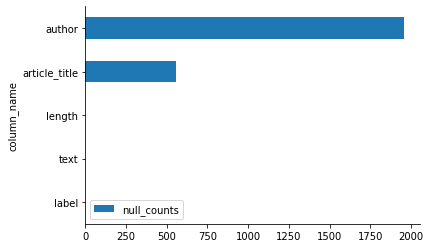

In [13]:

null_plot(df,'barh')

In [14]:

values = {'author' : 'Unknown', 'article_title': 'Unknown'}
df.fillna(value=values, inplace=True)

length           0
text             0
author           0
article_title    0
label            0
dtype: int64


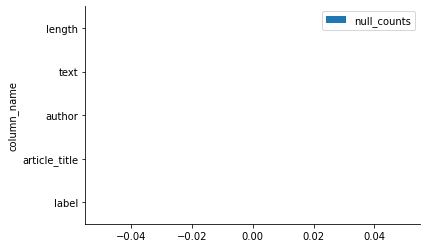

In [25]:
null_plot(df,'barh')

In [15]:

# Drop rows that have article length less than 50 characters
df.drop(df[df['length'] < 50].index, inplace = True)

In [27]:
print(df.shape)
df.head(5)

(20554, 5)


,label,article_title,author,text,length
0,1,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,4886
1,0,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,4143
2,1,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",7670
3,1,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,3223
4,1,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print An Iranian woman has been sentenced to s...,934


In [16]:
df['text_polarity'] = df['text'].apply(lambda x: TextBlob(x).sentiment.polarity)

In [29]:
df.head()

,label,article_title,author,text,length,text_polarity
0,1,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,4886,0.001796
1,0,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,4143,0.100880
2,1,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",7670,0.056258
3,1,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,3223,0.017497
4,1,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print An Iranian woman has been sentenced to s...,934,-0.012500


In [17]:
neg_tp = df[df['text_polarity'] < 0]
pos_tp = df[df['text_polarity'] > 0]

In [18]:
fake_df = df[df['label'] == 0]
real_df = df[df['label'] == 1]

The mean of text polarity in all articles is: 0.071
The median of text polarity in all articles is: 0.071


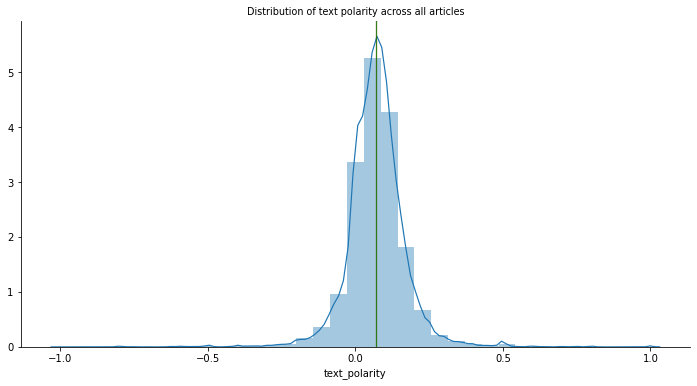

In [32]:
dist_plot(df, 'text_polarity', 'Distribution of text polarity across all articles', 'all articles')

The mean of text polarity in real articles is: 0.069
The median of text polarity in real articles is: 0.065


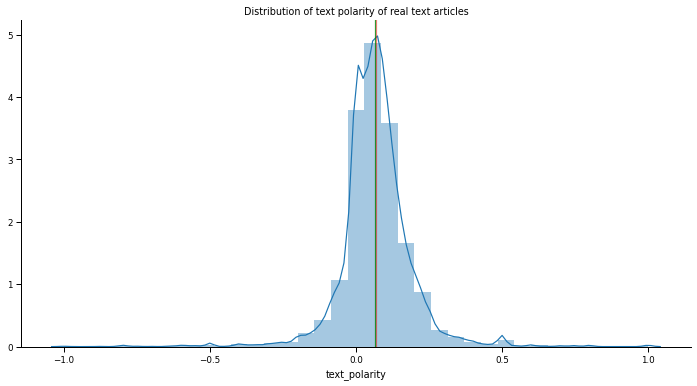

In [33]:
dist_plot(real_df, 'text_polarity', 'Distribution of text polarity of real text articles', 'real articles')

The mean of text polarity in fake articles is: 0.074
The median of text polarity in fake articles is: 0.075


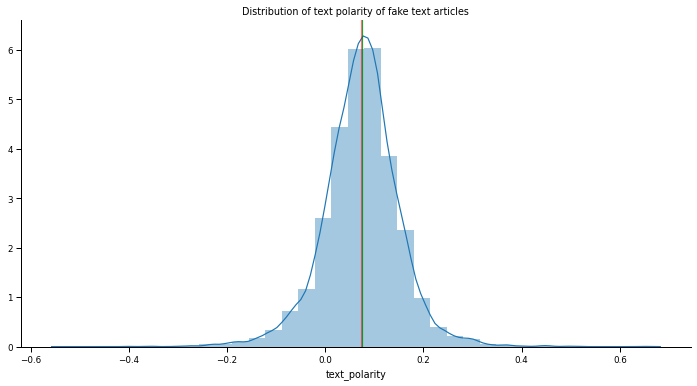

In [34]:

dist_plot(fake_df, 'text_polarity', 'Distribution of text polarity of fake text articles', 'fake articles')

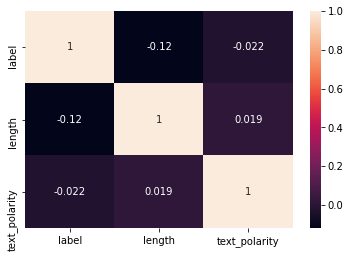

In [19]:
# Create a heatmap 
corr = df.corr()
sns.heatmap(corr, annot=True)
plt.show()

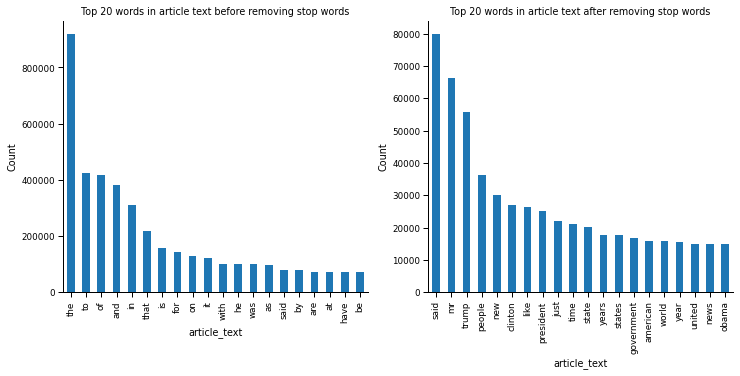

In [36]:

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))

# Top unigrams before removing stop words (sw)

uni_words_sw = get_top_n_words(df['text'], 20)

df1 = pd.DataFrame(uni_words_sw, columns=['article_text', 'count'])
df1.groupby('article_text').sum()['count'].sort_values(ascending=False).plot(kind='bar', 
                                                                            title='Top 20 words in article text before removing stop words', ax=ax1)
ax1.set(ylabel='Count')
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)

# Top unigrams after removing stop words
uni_words_no_sw = get_top_n_words_nosw(df['text'], 20)

df2 = pd.DataFrame(uni_words_no_sw, columns=['article_text', 'count'])
ax2.set(ylabel='Count')
df2.groupby('article_text').sum()['count'].sort_values(ascending=False).plot(kind='bar', 
                                                                            title='Top 20 words in article text after removing stop words', ax=ax2)
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
plt.show()

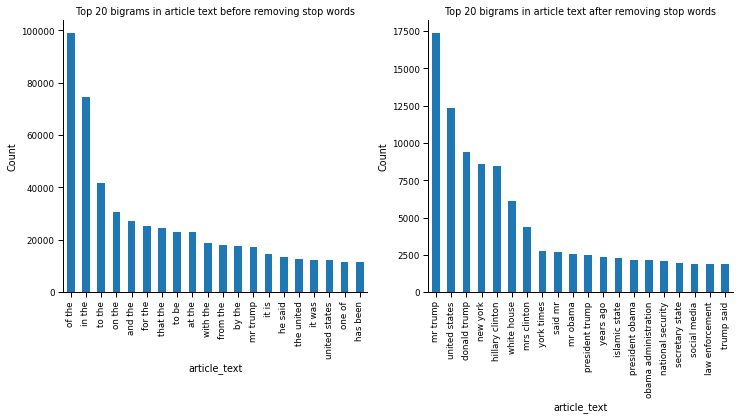

In [37]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))

# Top bigrams before removing stop words

bi_words_sw = get_top_n_bigram(df['text'], 20)

df3 = pd.DataFrame(bi_words_sw, columns=['article_text', 'count'])
df3.groupby('article_text').sum()['count'].sort_values(ascending=False).plot(kind='bar', 
                                                                            title='Top 20 bigrams in article text before removing stop words',
                                                                            ax=ax1)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.set(ylabel= 'Count')

# Top bigrams after removing stop words
bi_words_nosw = get_top_n_bigram_nosw(df['text'], 20)

df4 = pd.DataFrame(bi_words_nosw, columns=['article_text', 'count'])
df4.groupby('article_text').sum()['count'].sort_values(ascending=False).plot(kind='bar', 
                                                                            title='Top 20 bigrams in article text after removing stop words',
                                                                            ax=ax2)
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.set(ylabel = 'Count')
plt.show()

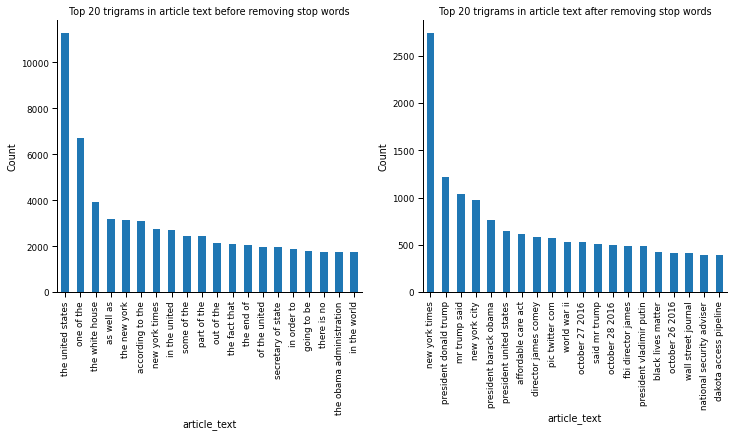

In [40]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))

# Top trigrams before removing stop words

tri_words_sw = get_top_n_trigram(df['text'], 20)

df5 = pd.DataFrame(tri_words_sw, columns=['article_text', 'count'])
df5.groupby('article_text').sum()['count'].sort_values(ascending=False).plot(kind='bar', 
                                                                            title='Top 20 trigrams in article text before removing stop words',
                                                                            ax=ax1)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.set(ylabel= 'Count')

# Top trigrams after removing stop words
tri_words_nosw = get_top_n_trigram_nosw(df['text'], 20)

df6 = pd.DataFrame(tri_words_nosw, columns=['article_text', 'count'])
df6.groupby('article_text').sum()['count'].sort_values(ascending=False).plot(kind='bar', 
                                                                            title='Top 20 trigrams in article text after removing stop words',
                                                                            ax=ax2)
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.set(ylabel = 'Count')
plt.show()

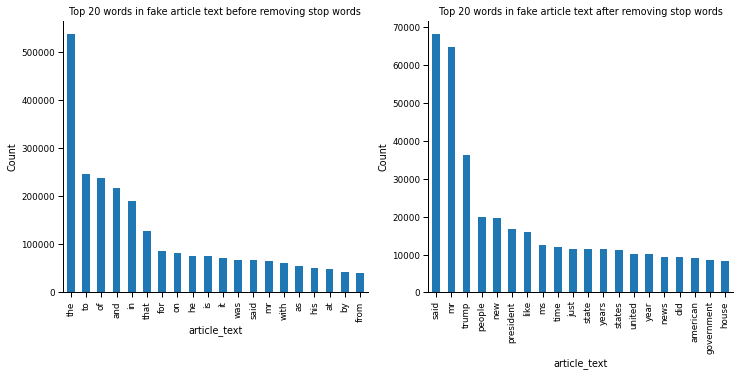

In [39]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))

# Top unigrams before removing stop words (sw) in fake articles' text 

fake_uni_words_sw = get_top_n_words(fake_df['text'], 20)

df_fake_1 = pd.DataFrame(fake_uni_words_sw, columns=['article_text', 'count'])
df_fake_1.groupby('article_text').sum()['count'].sort_values(ascending=False).plot(kind='bar', 
                                                                            title='Top 20 words in fake article text before removing stop words', ax=ax1)

ax1.set(ylabel='Count')
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
# Top unigrams after removing stop words (sw) in fake articles' text 
fake_uni_words_no_sw = get_top_n_words_nosw(fake_df['text'], 20)

df_fake_2 = pd.DataFrame(fake_uni_words_no_sw, columns=['article_text', 'count'])
df_fake_2.groupby('article_text').sum()['count'].sort_values(ascending=False).plot(kind='bar', 
                                                                            title='Top 20 words in fake article text after removing stop words', ax=ax2)
ax2.set(ylabel='Count')
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
plt.show()

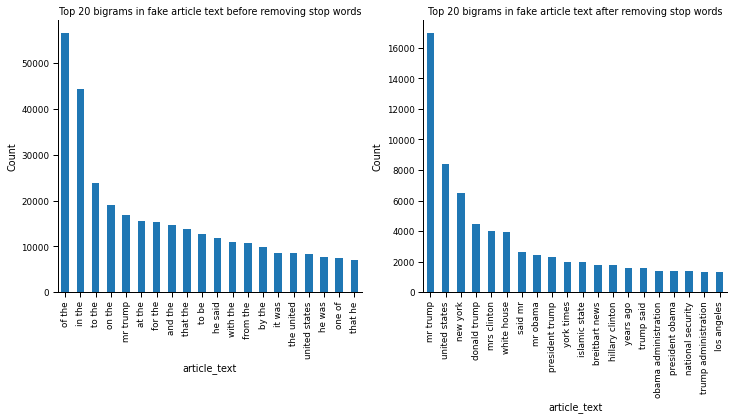

In [41]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))

# Top bigrams before removing stop words

fake_bi_words_sw = get_top_n_bigram(fake_df['text'], 20)

df_fake_3 = pd.DataFrame(fake_bi_words_sw, columns=['article_text', 'count'])
df_fake_3.groupby('article_text').sum()['count'].sort_values(ascending=False).plot(kind='bar', 
                                                                            title='Top 20 bigrams in fake article text before removing stop words',
                                                                            ax=ax1)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.set(ylabel= 'Count')

# Top bigrams after removing stop words
fake_bi_words_nosw = get_top_n_bigram_nosw(fake_df['text'], 20)

df_fake_4 = pd.DataFrame(fake_bi_words_nosw, columns=['article_text', 'count'])
df_fake_4.groupby('article_text').sum()['count'].sort_values(ascending=False).plot(kind='bar', 
                                                                            title='Top 20 bigrams in fake article text after removing stop words',
                                                                            ax=ax2)
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.set(ylabel = 'Count')
plt.show()

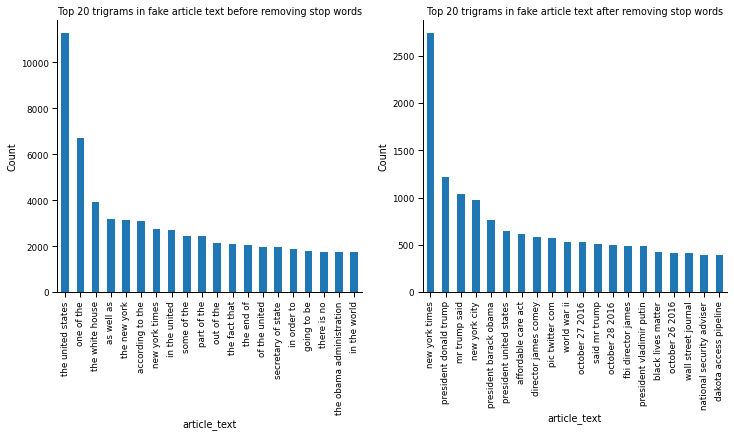

In [42]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))

# Top trigrams before removing stop words

fake_tri_words_sw = get_top_n_trigram(df['text'], 20)

df_fake_5 = pd.DataFrame(fake_tri_words_sw, columns=['article_text', 'count'])
df_fake_5.groupby('article_text').sum()['count'].sort_values(ascending=False).plot(kind='bar', 
                                                                            title='Top 20 trigrams in fake article text before removing stop words',
                                                                            ax=ax1)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.set(ylabel= 'Count')

# Top trigrams after removing stop words
fake_tri_words_nosw = get_top_n_trigram_nosw(df['text'], 20)

df_fake_6 = pd.DataFrame(fake_tri_words_nosw, columns=['article_text', 'count'])
df_fake_6.groupby('article_text').sum()['count'].sort_values(ascending=False).plot(kind='bar', 
                                                                            title='Top 20 trigrams in fake article text after removing stop words',
                                                                            ax=ax2)
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.set(ylabel = 'Count')
plt.show()

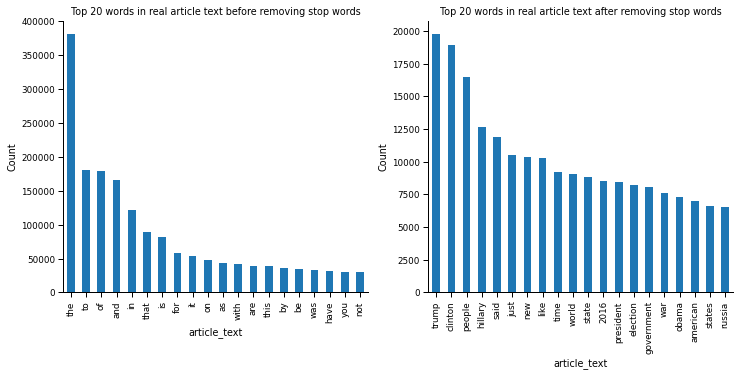

In [43]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))

# Top unigrams before removing stop words (sw) in real articles' text 

real_uni_words_sw = get_top_n_words(real_df['text'], 20)

df_real_1 = pd.DataFrame(real_uni_words_sw, columns=['article_text', 'count'])
df_real_1.groupby('article_text').sum()['count'].sort_values(ascending=False).plot(kind='bar', 
                                                                            title='Top 20 words in real article text before removing stop words', ax=ax1)
ax1.set(ylabel='Count')
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)

# Top unigrams after removing stop words (sw) in real articles' text 
real_uni_words_no_sw = get_top_n_words_nosw(real_df['text'], 20)

df_real_2 = pd.DataFrame(real_uni_words_no_sw, columns=['article_text', 'count'])
df_real_2.groupby('article_text').sum()['count'].sort_values(ascending=False).plot(kind='bar', 
                                                                            title='Top 20 words in real article text after removing stop words', ax=ax2)
ax2.set(ylabel='Count')
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
plt.show()

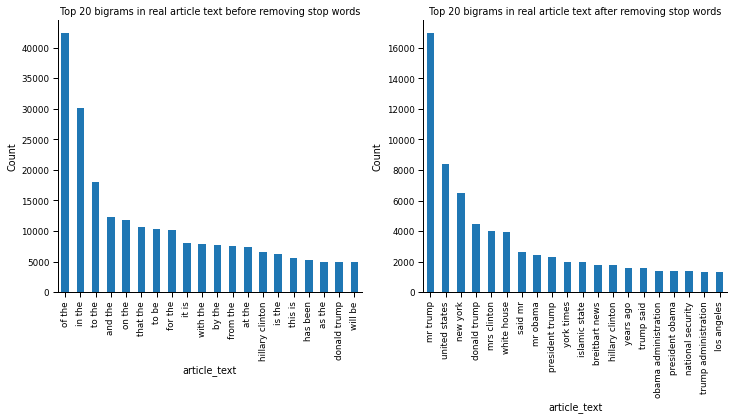

In [44]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))

# Top bigrams before removing stop words in real articles' text

real_bi_words_sw = get_top_n_bigram(real_df['text'], 20)

df_real_3 = pd.DataFrame(real_bi_words_sw, columns=['article_text', 'count'])
df_real_3.groupby('article_text').sum()['count'].sort_values(ascending=False).plot(kind='bar', 
                                                                            title='Top 20 bigrams in real article text before removing stop words',
                                                                            ax=ax1)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.set(ylabel= 'Count')

# Top bigrams after removing stop words in real articles' text

real_bi_words_nosw = get_top_n_bigram_nosw(fake_df['text'], 20)

df_fake_4 = pd.DataFrame(real_bi_words_nosw, columns=['article_text', 'count'])
df_fake_4.groupby('article_text').sum()['count'].sort_values(ascending=False).plot(kind='bar', 
                                                                            title='Top 20 bigrams in real article text after removing stop words',
                                                                            ax=ax2)
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.set(ylabel = 'Count')
plt.show()

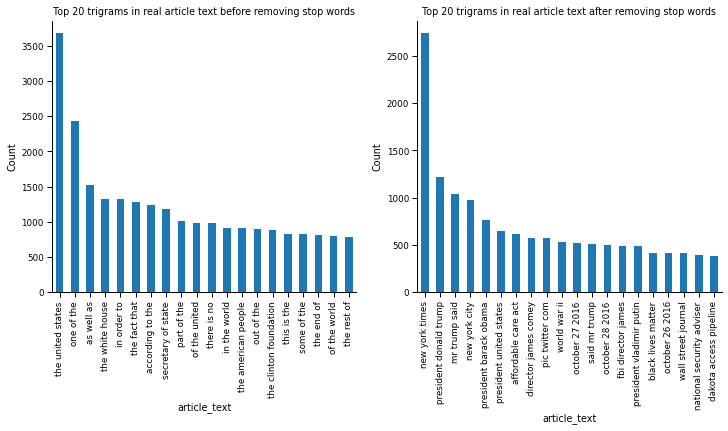

In [45]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))

# Top trigrams before removing stop words in real articles' text

real_tri_words_sw = get_top_n_trigram(real_df['text'], 20)

df_real_5 = pd.DataFrame(real_tri_words_sw, columns=['article_text', 'count'])
df_real_5.groupby('article_text').sum()['count'].sort_values(ascending=False).plot(kind='bar', 
                                                                            title='Top 20 trigrams in real article text before removing stop words',
                                                                            ax=ax1)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.set(ylabel= 'Count')

# Top trigrams after removing stop words in real articles' text
real_tri_words_nosw = get_top_n_trigram_nosw(df['text'], 20)

df_real_6 = pd.DataFrame(real_tri_words_nosw, columns=['article_text', 'count'])
df_real_6.groupby('article_text').sum()['count'].sort_values(ascending=False).plot(kind='bar', 
                                                                            title='Top 20 trigrams in real article text after removing stop words',
                                                                            ax=ax2)
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.set(ylabel = 'Count')
plt.show()

In [20]:
# Look at the means of the credit score of customers who exited and all bank customers 
mean_all_articles  =   df['text_polarity'].mean()
mean_fake_articles = fake_df['text_polarity'].mean()

print('The mean text polarity of all articles is ' + str(mean_all_articles))
print('The mean text polarity of fake articles is ' + str(mean_fake_articles))

The mean text polarity of all articles is 0.07129251085549954
The mean text polarity of fake articles is 0.0735741624574898


In [21]:
stats.ttest_1samp(a=  fake_df['text_polarity'], # Sample of text polarity ofarticles that are fake 
                  popmean = mean_all_articles) # Mean of the population

Ttest_1sampResult(statistic=3.020018793001539, pvalue=0.0025337349388929752)

In [22]:
degree_of_freedom = len(df[df['label']==1])

left_quartile = stats.t.ppf(0.025,degree_of_freedom)  # Left Quartile

right_quartile = stats.t.ppf(0.975,degree_of_freedom)  # Right Quartile

print ('The t-distribution left quartile range is: ' + str(left_quartile))
print ('The t-distribution right quartile range is: ' + str(right_quartile))

The t-distribution left quartile range is: -1.960197296450186
The t-distribution right quartile range is: 1.9601972964501855


In [23]:
sigma = fake_df['text_polarity'].std()/math.sqrt(degree_of_freedom + 1)  # Sample stdev/sample size

stats.t.interval(0.95,                        # Confidence level
                 df = degree_of_freedom,                     # Degrees of freedom
                 loc = mean_fake_articles, # Sample mean
                 scale= sigma)

(0.07207764342443139, 0.0750706814905482)

In [24]:
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(df['text'],y, test_size=0.2, random_state=40)

In [25]:
count_vectorizer = CountVectorizer(stop_words='english')
count_train = count_vectorizer.fit_transform(X_train)
count_test = count_vectorizer.transform(X_test)

In [26]:
tfidf_vectorizer = TfidfVectorizer(stop_words='english')
tfidf_train = tfidf_vectorizer.fit_transform(X_train)
tfidf_test = tfidf_vectorizer.transform(X_test)

In [ ]:
count_df = pd.DataFrame(count_train.A, columns=count_vectorizer.get_feature_names())
tfidf_df = pd.DataFrame(tfidf_train.A, columns=tfidf_vectorizer.get_feature_names())

In [1]:
log_reg_classifier(LogisticRegression, 'balanced', 0.01, count_train, y_train, count_test, y_test)

NameError: ignored

In [2]:

log_reg_classifier(LogisticRegression, 'balanced', 0.01, tfidf_train, y_train, tfidf_test, y_test)

NameError: ignored

Hyper-parameter tuning

# New Section

In [ ]:
alphas = np.arange(0,1,0.1)

In [ ]:
# -- Hyper-parameter tuning for Decision Tree Classifier -- 

classifier= MultinomialNB()
grid_param = {'alpha': alphas}
gd_sr = GridSearchCV(estimator=classifier,
                     param_grid=grid_param,
                     scoring='roc_auc',
                     cv=10,
                     n_jobs=-1)

gd_sr.fit(count_train,y_train)
best_parameters = gd_sr.best_params_
print(best_parameters)

In [ ]:
# -- Hyper-parameter tuning for Decision Tree Classifier -- 

classifier= MultinomialNB()
grid_param = {'alpha': alphas}

gd_sr = GridSearchCV(estimator=classifier,
                     param_grid=grid_param,
                     scoring='roc_auc',
                     cv=10,
                     n_jobs=-1)

gd_sr.fit(tfidf_train, y_train)
best_parameters = gd_sr.best_params_
print(best_parameters)

In [ ]:
mnb_classifier(MultinomialNB, 0.1, count_train, y_train, count_test, y_test)

In [ ]:
mnb_classifier(MultinomialNB, 0.1, tfidf_train, y_train, tfidf_test, y_test)

In [ ]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 50000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 250
# This is fixed.
EMBEDDING_DIM = 100

In [ ]:
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df['text'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

In [ ]:
X = tokenizer.texts_to_sequences(df['text'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

In [ ]:
Y = pd.get_dummies(df['label']).values

In [ ]:

X_Train, X_Test, Y_Train, Y_Test = train_test_split(X,Y, test_size = 0.20, random_state = 42)
print(X_Train.shape,Y_Train.shape)
print(X_Test.shape,Y_Test.shape)

In [ ]:
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.1, recurrent_dropout=0.1))
model.add(Dense(2, activation='softmax'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

epochs = 15
batch_size = 64

history = model.fit(X_Train, Y_Train, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

In [ ]:
accr = model.evaluate(X_Test,Y_Test)
print('Test set\n  Loss: {:0.2f}\n  Accuracy: {:0.2f}'.format(accr[0],accr[1]))

In [ ]:
yhat_classes = model.predict_classes(X_Test, verbose=0)
y_temp_pred = [1 if x[1] == 1 else 0 for x in Y_Test]

In [ ]:
print("-- LSTM Neural Network on Tokenized Text --")
lstm_auc_score = roc_auc_score(y_temp_pred, yhat_classes)
print("-- LSTM Neural Network on Tokenized Text AUC = %2.2f --" % lstm_auc_score)
print("-- LSTM Neural Network on Tokenized Text Accuracy = %2.2f --" % accr[1])
print("\n")
print(confusion_matrix(y_temp_pred, yhat_classes))
print("\n")
print(classification_report(y_temp_pred, yhat_classes))

In [ ]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
plt.show();

In [ ]:

plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.title('model train vs validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend()
plt.show();

In [ ]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_test, nb_classifier.predict_proba(count_test)[:,1])
tdidf_fpr, tdidf_tpr, tdidf_thresholds = roc_curve(y_test, nb_tfidf_classifier.predict_proba(tfidf_test)[:,1])
fpr_lr, tpr_lr, thresholds_lr = roc_curve(y_test, log_reg.predict_proba(count_test)[:,1])
fpr_lr_tfidf, tpr_lr_tfidf, thresholds_lr_tfidf = roc_curve(y_test, log_reg_tfidf.predict_proba(tfidf_test)[:,1])

plt.figure()

# Plot Logistic Regression ROC with Count Vectorizer 
plt.plot(fpr_lr, tpr_lr, label='Logistic Regression with Count Vectorizer (area = %0.2f)' % log_reg_auc_score)
# Plot Logistic Regression ROC with TFIDF

plt.plot(fpr_lr_tfidf, tpr_lr_tfidf, label='Logistic Regression with TF-IDF (area = %0.2f)' % log_reg_tfidf_auc_score)

# Plot Multinomial NB with count vectorizer 
plt.plot(fpr, tpr, label='Multinomial NB with Count Vectorizer (area = %0.2f)' % mnb_cv_auc_score)

# Plot Multinomial NB with TF-IDF
plt.plot(tdidf_fpr, tdidf_tpr, label='Multinomial NB with TF-IDF (area = %0.2f)' % mnb_tfidf_auc_score)

# Plot LSTM 
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_temp_pred, yhat_classes)
auc_keras = auc(fpr_keras, tpr_keras)
plt.plot(fpr_keras, tpr_keras, label='LSTM (area = {:.2f})'.format(auc_keras))

# Plot Base Rate ROC
plt.plot([0,1], [0,1],label='Base Rate')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Graph')
plt.legend(loc="best")
plt.show()